In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter

class CCTAVisualDataset(Dataset):
    def __init__(self, size=16, num_samples=30):
        self.size = size
        self.num_samples = num_samples
        self.samples = []
        
        print("Generating synthetic dataset...")
        for _ in tqdm(range(num_samples)):
            self.samples.append(self.generate_sample())

    def centerline_to_volume(self, centerline):
        """Convert centerline points to volume representation"""
        volume = np.zeros((self.size, self.size, self.size))
        centerline_rounded = np.round(centerline).astype(int)
        # Clip to ensure within bounds
        centerline_rounded = np.clip(centerline_rounded, 0, self.size-1)
        volume[centerline_rounded[:,0], centerline_rounded[:,1], centerline_rounded[:,2]] = 1
        return volume
    
    def generate_curved_centerline(self):
        """Generate a curved centerline path"""
        t = np.linspace(0, 2*np.pi, self.size)
        x = self.size/2 + self.size/4 * np.cos(t)
        y = np.linspace(0, self.size-1, self.size)
        z = self.size/2 + self.size/4 * np.sin(t)
        return np.stack([x, y, z], axis=1)

    def generate_vessel_from_centerline(self, centerline, radius=2):
        """Generate a vessel volume from centerline"""
        volume = np.zeros((self.size, self.size, self.size))
        x, y, z = np.meshgrid(np.arange(self.size),
                             np.arange(self.size),
                             np.arange(self.size),
                             indexing='ij')
        coords = np.stack([x, y, z], axis=-1)
        
        for point in centerline:
            dist = np.sqrt(np.sum((coords - point)**2, axis=-1))
            volume[dist < radius] = 1
        return volume

    def generate_sample(self):
        """Generate one CCTA-like sample with vessel and centerline"""
        # Generate centerline
        centerline = self.generate_curved_centerline()
        
        # Generate vessel
        vessel = self.generate_vessel_from_centerline(centerline)
        
        # Convert to tensor for Gaussian filtering
        vessel_tensor = torch.FloatTensor(vessel)
        noise = torch.randn_like(vessel_tensor) * 0.1
        vessel_tensor = vessel_tensor + noise
        
        # Apply Gaussian filtering
        vessel_filtered = gaussian_filter(vessel_tensor, sigma=0.5)
        
        # Generate quality score (synthetic)
        quality_score = np.random.uniform(0.5, 1.0)
        
        # Generate plaque (synthetic)
        plaque_mask = np.zeros_like(vessel)
        plaque_mask[vessel > 0.5] = np.random.randint(0, 4, size=np.sum(vessel > 0.5))
        
        return {
            'image': torch.Tensor(vessel_filtered).unsqueeze(0),
            'centerline': torch.FloatTensor(self.centerline_to_volume(centerline)).unsqueeze(0),
            'quality_score': torch.FloatTensor([quality_score]),
            'plaque_mask': torch.LongTensor(plaque_mask)
        }

    

    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.samples[idx]

In [2]:
class VGG19_IQA(nn.Module):
    def __init__(self, input_channels=1):
        super(VGG19_IQA, self).__init__()
        self.features = nn.Sequential(
            nn.Conv3d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16 * 16, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [3]:
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet3D, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        
        # Decoder
        self.dec3 = self.conv_block(256, 128)
        self.dec2 = self.conv_block(128, 64)
        self.dec1 = self.conv_block(64, out_channels)
        
        self.final = nn.Conv3d(out_channels, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool3d(e1, 2))
        e3 = self.enc3(F.max_pool3d(e2, 2))
        
        # Decoder
        d3 = self.dec3(e3)
        d2 = self.dec2(F.interpolate(d3, size=e2.shape[2:]))
        d1 = self.dec1(F.interpolate(d2, size=e1.shape[2:]))
        
        return torch.sigmoid(self.final(d1))


In [4]:
class CCTAAnalysisPipeline:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.quality_model = VGG19_IQA().to(device)
        self.segmentation_model = UNet3D().to(device)
        
        # Optimizers
        self.quality_optimizer = torch.optim.Adam(self.quality_model.parameters())
        self.seg_optimizer = torch.optim.Adam(self.segmentation_model.parameters())
        
        # Loss functions
        self.quality_criterion = nn.MSELoss()
        self.seg_criterion = nn.BCELoss()
        
    def train_epoch(self, dataloader, epoch):
        self.quality_model.train()
        self.segmentation_model.train()
        
        total_quality_loss = 0
        total_seg_loss = 0
        
        for batch in tqdm(dataloader, desc=f'Epoch {epoch}'):
            # Move data to device
            images = batch['image'].to(self.device)
            centerlines = batch['centerline'].to(self.device)
            quality_scores = batch['quality_score'].to(self.device)
            
            # Train quality assessment
            self.quality_optimizer.zero_grad()
            quality_pred = self.quality_model(images)
            quality_loss = self.quality_criterion(quality_pred, quality_scores)
            quality_loss.backward()
            self.quality_optimizer.step()
            
            # Train segmentation
            self.seg_optimizer.zero_grad()
            seg_pred = self.segmentation_model(images)
            seg_loss = self.seg_criterion(seg_pred, centerlines)
            seg_loss.backward()
            self.seg_optimizer.step()
            
            total_quality_loss += quality_loss.item()
            total_seg_loss += seg_loss.item()
            
        avg_quality_loss = total_quality_loss / len(dataloader)
        avg_seg_loss = total_seg_loss / len(dataloader)
        
        return avg_quality_loss, avg_seg_loss
    
    def validate(self, dataloader):
        self.quality_model.eval()
        self.segmentation_model.eval()
        
        total_quality_loss = 0
        total_seg_loss = 0
        
        with torch.no_grad():
            for batch in dataloader:
                images = batch['image'].to(self.device)
                centerlines = batch['centerline'].to(self.device)
                quality_scores = batch['quality_score'].to(self.device)
                
                quality_pred = self.quality_model(images)
                seg_pred = self.segmentation_model(images)
                
                quality_loss = self.quality_criterion(quality_pred, quality_scores)
                seg_loss = self.seg_criterion(seg_pred, centerlines)
                
                total_quality_loss += quality_loss.item()
                total_seg_loss += seg_loss.item()
        
        avg_quality_loss = total_quality_loss / len(dataloader)
        avg_seg_loss = total_seg_loss / len(dataloader)
        
        return avg_quality_loss, avg_seg_loss


In [5]:
def visualize_results(sample, seg_pred):
    """Visualize original image, true centerline, and predicted centerline"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image (middle slice)
    axes[0].imshow(sample['image'][0, 0, :, :, sample['image'].shape[3]//2].cpu())
    axes[0].set_title('Original Image')
    
    # True centerline
    axes[1].imshow(sample['centerline'][0, 0, :, :, sample['centerline'].shape[3]//2].cpu())
    axes[1].set_title('True Centerline')
    
    # Predicted centerline
    axes[2].imshow(seg_pred[0, 0, :, :, seg_pred.shape[3]//2].cpu().detach())
    axes[2].set_title('Predicted Centerline')
    
    plt.tight_layout()
    plt.show()
    
def visualize_results_3d(sample, seg_pred):
    """Visualize centerline in 3D"""
    fig = plt.figure(figsize=(15, 5))
    
    # Original centerline
    ax1 = fig.add_subplot(131, projection='3d')
    centerline = sample['centerline'][0, 0].cpu().numpy()
    x, y, z = np.where(centerline > 0.5)
    ax1.scatter(x, y, z, c='r', marker='.')
    ax1.set_title('True Centerline')
    
    # Predicted centerline
    ax2 = fig.add_subplot(132, projection='3d')
    pred = seg_pred[0, 0].cpu().detach().numpy()
    x, y, z = np.where(pred > 0.5)
    ax2.scatter(x, y, z, c='b', marker='.')
    ax2.set_title('Predicted Centerline')
    
    # Original image (middle slice for reference)
    ax3 = fig.add_subplot(133)
    ax3.imshow(sample['image'][0, 0, :, :, sample['image'].shape[3]//2].cpu())
    ax3.set_title('Original Image (Mid Slice)')
    
    plt.tight_layout()
    plt.show()


Generating synthetic dataset...


Epoch 0: 100%|██████████| 20/20 [10:25<00:00, 31.30s/it]


Epoch 1/10:
Train - Quality Loss: 0.0740, Seg Loss: 1.1591
Val - Quality Loss: 0.0641, Seg Loss: 1.1120


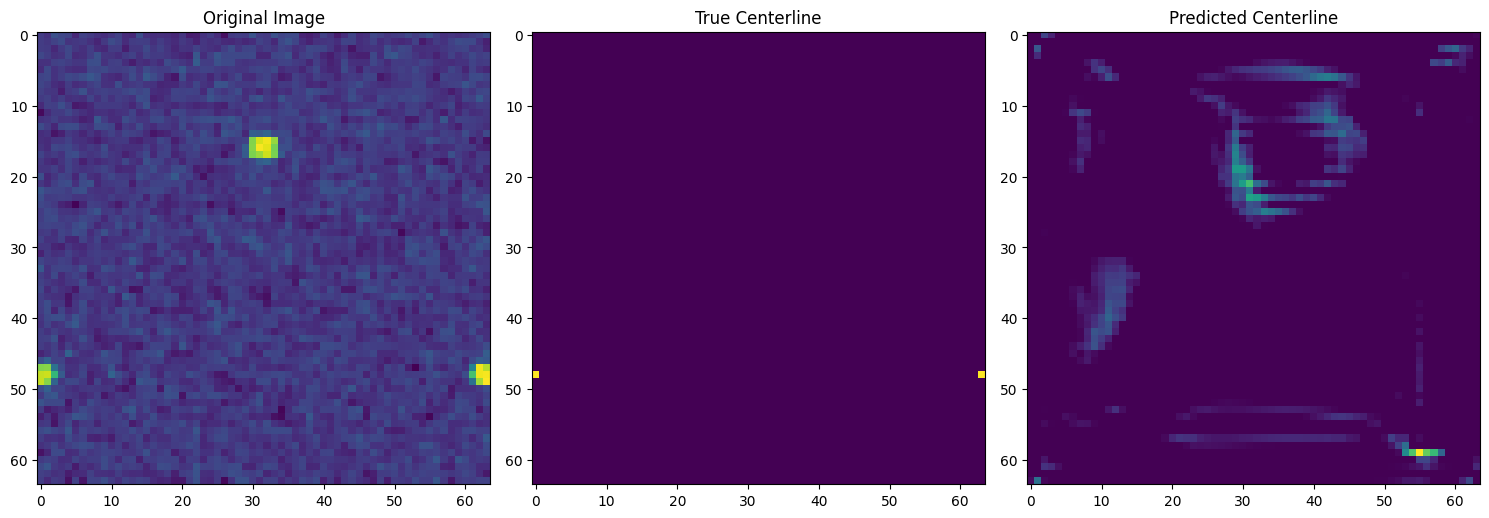

Epoch 1:   0%|          | 0/20 [00:15<?, ?it/s]


KeyboardInterrupt: 

In [6]:
# Create dataset
dataset = CCTAVisualDataset(size=64, num_samples=100)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

# Initialize pipeline
pipeline = CCTAAnalysisPipeline()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_quality_loss, train_seg_loss = pipeline.train_epoch(train_loader, epoch)
    val_quality_loss, val_seg_loss = pipeline.validate(val_loader)
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train - Quality Loss: {train_quality_loss:.4f}, Seg Loss: {train_seg_loss:.4f}')
    print(f'Val - Quality Loss: {val_quality_loss:.4f}, Seg Loss: {val_seg_loss:.4f}')
    
    # Visualize results for first validation sample
    if epoch % 2 == 0:
        sample = next(iter(val_loader))
        with torch.no_grad():
            seg_pred = pipeline.segmentation_model(sample['image'].to(pipeline.device))
        visualize_results(sample, seg_pred)

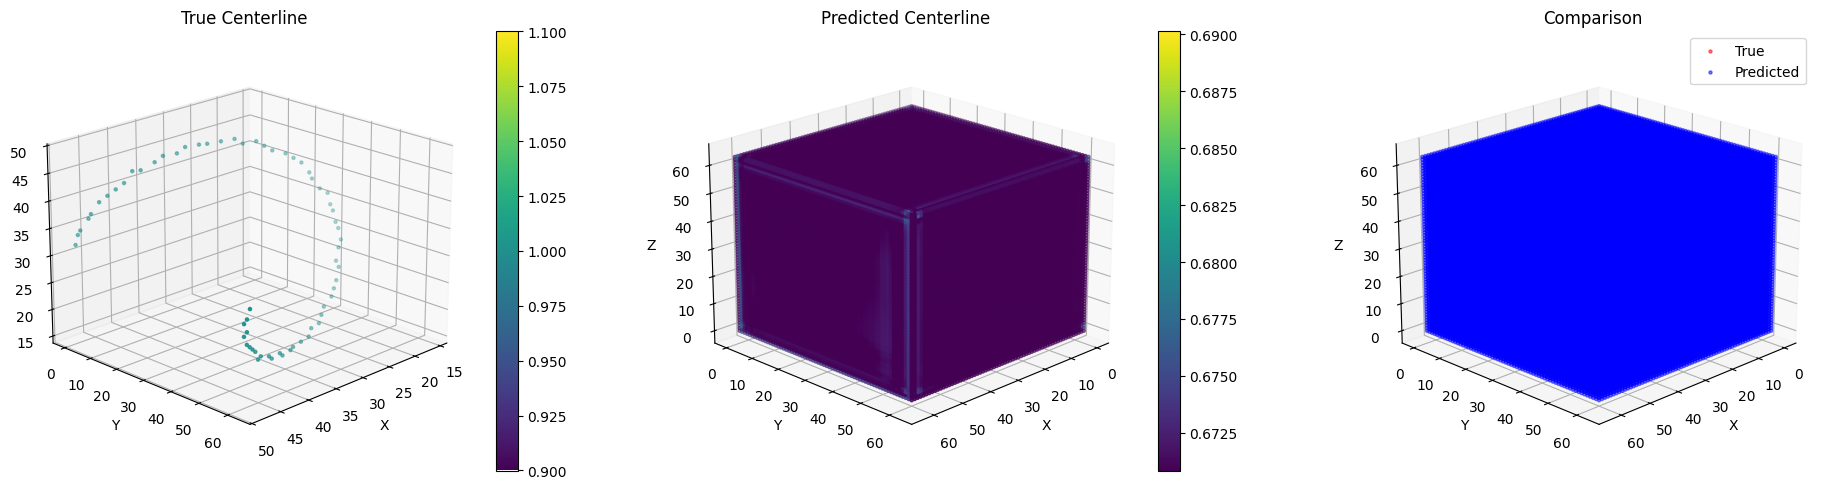

In [9]:
def visualize_results_3d(sample, seg_pred, threshold=0.5):
    """Enhanced 3D visualization"""
    fig = plt.figure(figsize=(20, 5))
    
    # Plot original centerline
    ax1 = fig.add_subplot(131, projection='3d')
    centerline = sample['centerline'][0, 0].cpu().numpy()
    x, y, z = np.where(centerline > threshold)
    scatter1 = ax1.scatter(x, y, z, c=centerline[x, y, z], cmap='viridis', marker='.')
    ax1.set_title('True Centerline')
    plt.colorbar(scatter1, ax=ax1)
    
    # Plot predicted centerline
    ax2 = fig.add_subplot(132, projection='3d')
    pred = seg_pred[0, 0].cpu().detach().numpy()
    x, y, z = np.where(pred > threshold)
    scatter2 = ax2.scatter(x, y, z, c=pred[x, y, z], cmap='viridis', marker='.')
    ax2.set_title('Predicted Centerline')
    plt.colorbar(scatter2, ax=ax2)
    
    # Plot both for comparison
    ax3 = fig.add_subplot(133, projection='3d')
    # True centerline in red
    x1, y1, z1 = np.where(centerline > threshold)
    ax3.scatter(x1, y1, z1, c='red', marker='.', label='True', alpha=0.5)
    # Predicted centerline in blue
    x2, y2, z2 = np.where(pred > threshold)
    ax3.scatter(x2, y2, z2, c='blue', marker='.', label='Predicted', alpha=0.5)
    ax3.set_title('Comparison')
    ax3.legend()
    
    # Set consistent viewing angle
    for ax in [ax1, ax2, ax3]:
        ax.view_init(elev=20, azim=45)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
    
    plt.tight_layout()
    plt.show()
visualize_results_3d(sample, seg_pred)